# Visualization Tool for Planet Imagery to QAQC & Analyze NDVI SITS
## Binary, QAQC and Visualiation Tools Integrated

This notebooks focuses on providing the tools necessary to QAQC Planet imagery and to visualization the changes in NDVI over a set or subset of images for a given Area of Interest (AOI). The intention is to be able to determine if a given AOI is increasing or decreasing in vegetation (i.e. greenness) and the general hotspots this may or may not be occurring. This notebook is intended to be used with other preprocessing tools and assumes that the user has a single directory containing analysis-ready NDVI rasters (i.e. single-band -1 to 1 *.tiffs).

#### Import Libary Setup

The libraries below must be installed in the Anaconda environment that the user is running this notebook from.

In [1]:
# Imported Python standard libraries
import os
import sys
import datetime
from functools import partial
import itertools
# Imported Python data manipulation libraries
import numpy as np
import pandas as pd
import rasterio
from skimage.filters import (threshold_minimum, threshold_li, threshold_isodata,
                             threshold_mean, threshold_otsu, try_all_threshold)
# Imported Python visualization libraries
import matplotlib
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import HBox, Label
from IPython.display import display, clear_output

#### User Provided Inputs Setup

Please specify the input folder directory containing all the Planet imagery to be analyzed as NDVI rasters.  
The absolute folder pathname is recommended along with the use of r" " to reverse the "\\" to "/" automatically.

In [2]:
# input folder directory
planet_input_dir = r"C:\Users\zleady\Desktop\ST_1867\LC\lcr_active_20200621\poh_final_NDVI"

In [3]:
def CreateImgPathList(img_folder):
    img_path_lst = [os.path.join(img_folder, f) 
                    for f in os.listdir(img_folder)
                    if f.endswith(".tif")]
    return img_path_lst

Invoke the CreateImgPathList function on the planet_input_dir.  
Displays to the user the first and last image/raster pathname and the total number of rasters in the list.

In [4]:
planet_img_path_lst = CreateImgPathList(planet_input_dir)
# Display output checks
print("First Pathname: ", planet_img_path_lst[0])
print("Last Pathname: ", planet_img_path_lst[-1])
print("Total Number of Pathnames: ", len(planet_img_path_lst))

First Pathname:  C:\Users\zleady\Desktop\ST_1867\LC\lcr_active_20200621\poh_final_NDVI\20160808_ndvi.tif
Last Pathname:  C:\Users\zleady\Desktop\ST_1867\LC\lcr_active_20200621\poh_final_NDVI\20190512_ndvi.tif
Total Number of Pathnames:  303


## Analysis of NDVI Images

#### Read-in NDVI Image Data

Read-in the NDVI images/rasters into a Python dictionary called "ndvi_img_dict". Each image has a date key in the format "YYYYMMDD", which is paired to another dictionary containing the keys "path", "original_array", "histo_array", and "display_array". The histo_array is modified to not contain any NaN's which are used for pixels with missing data by numpy when the image is read into a numpy array via the rasterio library. The display_array converts the NaN's into 0 for easier displaying with the matplotlib libraries "imshow()" function. This code block also ensures that each image is the same number of pixels on the x-axis and y-axis and filters images into the incorrect_shape_lst that are not the same shape.

In [5]:
# initialize image dictionary
ndvi_img_dict = {}
# initialize list for images with the wrong shape
incorrect_shape_lst = []

In [6]:
# primary data read-in loop
for p in planet_img_path_lst:    
    with rasterio.open(p) as ds:
        temp_arr = ds.read(1)
        temp_dict = {"path": p,
                     "original_array": temp_arr,
                     "histo_array": temp_arr[~np.isnan(temp_arr)],
                     "display_array": np.nan_to_num(temp_arr)}
        date_id = os.path.basename(p).split("_")[0]
        if p == planet_img_path_lst[0]:
            x0_shape = temp_arr.shape[0]
            y0_shape = temp_arr.shape[1]
            print("First x0_shape: {}, y0_shape: {}".format(x0_shape, y0_shape))
        if temp_arr.shape[0] == x0_shape and temp_arr.shape[1] == y0_shape:
            ndvi_img_dict[date_id] = temp_dict
        else:
            incorrect_shape_lst.append([date_id, temp_arr.shape])
    ds.close()

First x0_shape: 1669, y0_shape: 1354


In [7]:
img_key_lst = list(ndvi_img_dict.keys())
print("Images found to have an inconsistent shape [date, (array shape)]: ")
print(incorrect_shape_lst)
print("Started with {} Pathnames".format(len(planet_img_path_lst)))
print("Added {} to NDVI Image Dictionary".format(len(img_key_lst)))
print("Check that each image key has 4 keys: ",
      ndvi_img_dict.get("{}".format(img_key_lst[0])).keys())

Images found to have an inconsistent shape [date, (array shape)]: 
[['20170802', (1551, 1352)], ['20181206', (1323, 1347)], ['20181228', (1547, 1352)], ['20190502', (1381, 1347)]]
Started with 303 Pathnames
Added 299 to NDVI Image Dictionary
Check that each image key has 4 keys:  dict_keys(['path', 'original_array', 'histo_array', 'display_array'])


### Establish Binary Thresholding Method and Array Data

An NDVI image is a "derived" band and ranges between -1 to 1 with 1 signifying high vegetation or "greenness". Binary thresholding methods (algorithms) can be used to determine a seperation from vegetation and everything else. This is not the primary goal of NDVI tracking but can serve as a good QAQC check for creating a boundary around what might be an actual change in NDVI vs. a spurious or insignificant change in NDVI. Thus the binary threshold array should be viewed as a loose boundary of what to focus on versus the rest of the image.

In [8]:
# dictionary of binary threshold functions bound to string identifiers
# useful for looping functions
threshold_dict = {"iso": threshold_isodata, "li": threshold_li,
                  "mean": threshold_mean, "otsu": threshold_otsu,
                  "min": threshold_minimum}
# initialize list for dates that binary thresholding failed on for data/algo reasons
failed_threshold_lst = []

# binary thresholding loop
print("Starting thresholding loop")
for date in list(ndvi_img_dict.keys()):
    temp_arr = ndvi_img_dict.get(date).get("histo_array")
    print("Processing: {}".format(date))
    try:
        for k in list(threshold_dict.keys()):
            temp_threshold_val = threshold_dict.get(k)(temp_arr)
            temp_binary_array = ndvi_img_dict.get(date).get("display_array") > temp_threshold_val
            ndvi_img_dict.get(date)["{}_value".format(k)] = temp_threshold_val
            ndvi_img_dict.get(date)["{}_binary_array".format(k)] = temp_binary_array
    except:
        failed_threshold_lst.append([date])
        del ndvi_img_dict[date]
print("Finished")

Starting thresholding loop
Processing: 20160808
Processing: 20160811
Processing: 20160903
Processing: 20170327
Processing: 20170328
Processing: 20170402
Processing: 20170403
Processing: 20170412
Processing: 20170416
Processing: 20170419
Processing: 20170427
Processing: 20170502
Processing: 20170510
Processing: 20170515
Processing: 20170517
Processing: 20170519
Processing: 20170520
Processing: 20170526
Processing: 20170529
Processing: 20170603
Processing: 20170606
Processing: 20170612
Processing: 20170614
Processing: 20170617
Processing: 20170619
Processing: 20170622
Processing: 20170625
Processing: 20170626
Processing: 20170627
Processing: 20170628
Processing: 20170703
Processing: 20170704
Processing: 20170708
Processing: 20170710
Processing: 20170714
Processing: 20170716
Processing: 20170717
Processing: 20170718
Processing: 20170722
Processing: 20170727
Processing: 20170730
Processing: 20170805
Processing: 20170809
Processing: 20170810
Processing: 20170812
Processing: 20170815
Process

In [9]:
print("Failed to threshold the following dates: ")
print(failed_threshold_lst)
print("Started with {} number of images for thresholding".format(len(img_key_lst)))
print("Thresholded {0} images. {0} images available for analysis.".format(len(list(ndvi_img_dict.keys()))))
print("\n")
print("Check the new keys for each image: ")
print(ndvi_img_dict.get("{}".format(list(ndvi_img_dict.keys())[0])).keys())

Failed to threshold the following dates: 
[['20180616'], ['20190310']]
Started with 299 number of images for thresholding
Thresholded 297 images. 297 images available for analysis.


Check the new keys for each image: 
dict_keys(['path', 'original_array', 'histo_array', 'display_array', 'iso_value', 'iso_binary_array', 'li_value', 'li_binary_array', 'mean_value', 'mean_binary_array', 'otsu_value', 'otsu_binary_array', 'min_value', 'min_binary_array'])


### Visually Compare Thresholding Method Performance

Each Binary Thresholding Method (algorithm) works in a slightly different way to automatically determine the seperation on the NDVI image histogram for vegetation and non-vegetation. The function and visualizer below allow the user to determine over there set or subset of images which thresholding method to use; typically, depending on how conservative the user chooses to be.

In [10]:
def show_compare_thresholds(img_dict):
    """ Plotting function for binary threshold comparison
    """
    global threshold_dict # remove in the future, a shortcut for ipywidgets observer
    plt.figure(figsize=(24, 48))
    plt.subplot(6, 2, 1)
    plt.imshow(img_dict.get("display_array"), cmap=plt.cm.gray)
    plt.title("Original NDVI Image")
    plt.subplot(6, 2, 2)
    plt.hist(img_dict.get("histo_array"), bins=256)
    plt.title("Original NDVI Histogram")
    subplot_spacer = 2
    for indx, k in enumerate(list(threshold_dict.keys())):
        plt.subplot(6, 2, indx+1+subplot_spacer)
        plt.imshow(img_dict.get("{}_binary_array".format(k)), cmap=plt.cm.gray)
        plt.title('{} Binary NDVI Image'.format(k.upper()))
        plt.subplot(6, 2, indx+2+subplot_spacer)
        plt.hist(img_dict.get("histo_array"), bins=256)
        plt.axvline(img_dict.get("{}_value".format(k)), color="r")
        plt.title("{} Thresholded Histogram Value={}".format(k.upper(), round(float(img_dict.get("{}_value".format(k))), 4)))
        subplot_spacer += 1
    plt.show()

A Visualizer for the Binary Threshold Comparison using ipywidgets. Change the dropdown menu date to check different images.

Dropdown(description='Image Date:', index=3, options=('20160808', '20160811', '20160903', '20170327', '2017032…

20160808 20170327


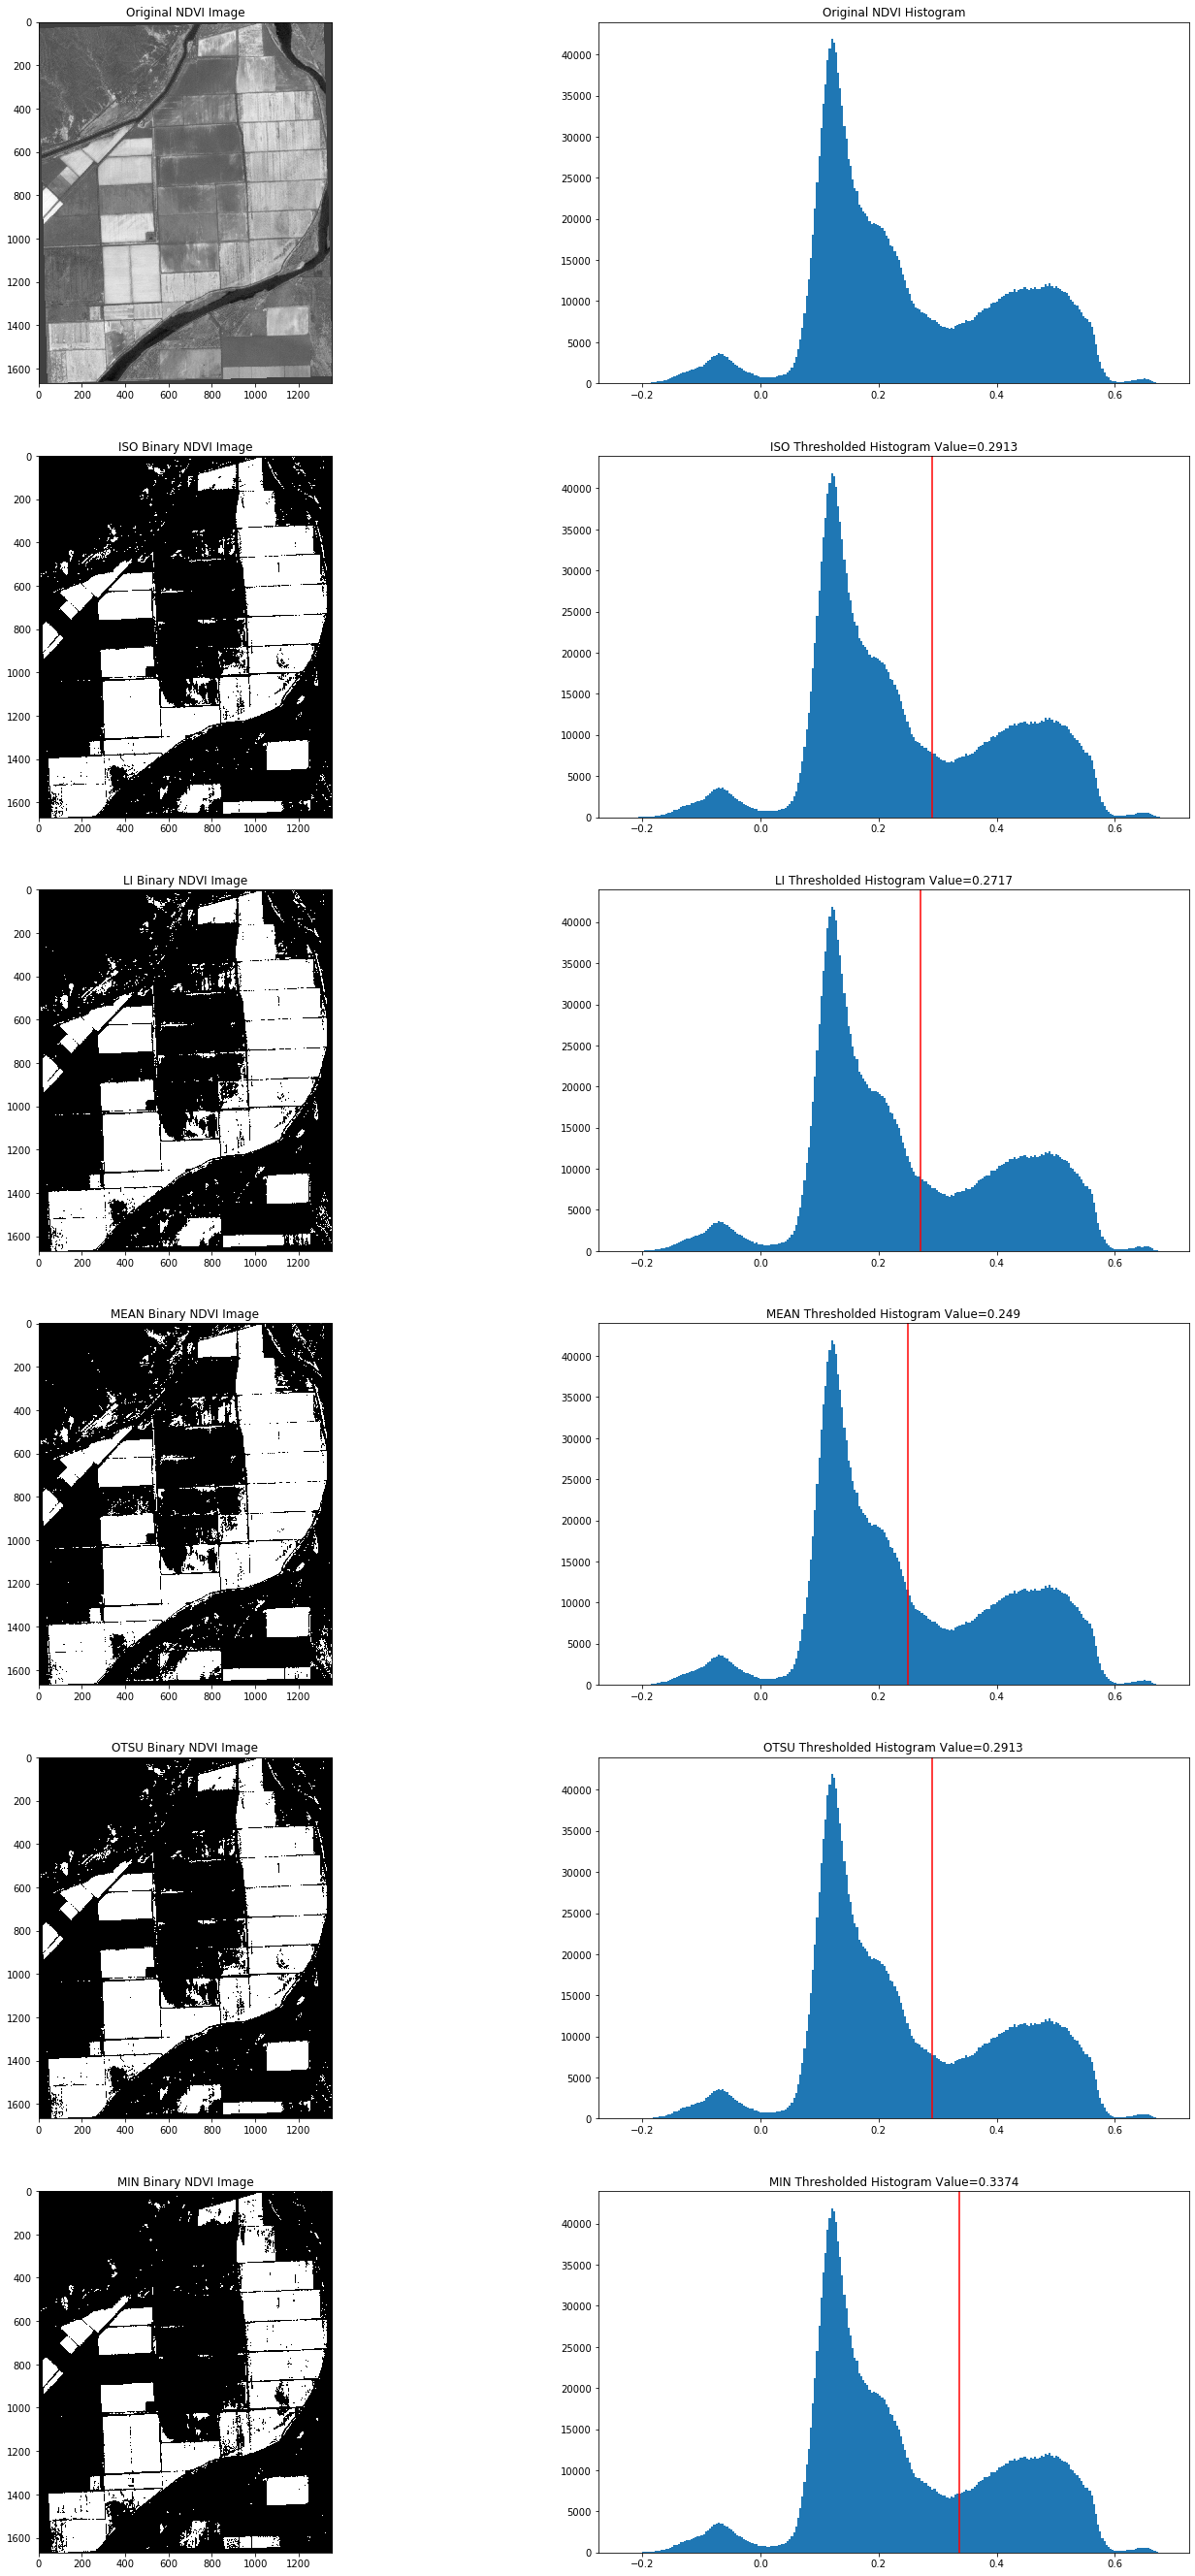

In [11]:
threshold_date_options_lst = sorted(list(ndvi_img_dict.keys()))
threshold_date_dropdown = widgets.Dropdown(options=threshold_date_options_lst,
                                           value=threshold_date_options_lst[0],
                                           description='Image Date:',)


def threshold_date_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output()
        display(threshold_date_dropdown)
        print(change['old'], change['new'])
        show_compare_thresholds(ndvi_img_dict.get("{}".format(change['new'])))

threshold_date_dropdown.observe(threshold_date_on_change)
display(threshold_date_dropdown)

#### User Set Binary Thresholding Algorithm

#### If a user is unsure on the binary thresholding algorithm choice OTSU is the literature default.
#### Zack's suggested default for a binary thresholding algorithm is MIN as its the most conservative.

Please set a binary thresholding algorithm below.

In [12]:
# options
print(threshold_dict.keys())

dict_keys(['iso', 'li', 'mean', 'otsu', 'min'])


In [13]:
# choosen binary thresholding algorithm
binary_algo = "otsu"

### Export Binary Thresholded NDVI Imagery

The following cells export the binary thresholded NDVI images as "*.tif" rasters using their original NDVI metadata.
  
The user can view the rasters in their preferred GIS program (i.e. ArcGIS, QGIS, etc.)  
OR  
the rasters can be read by a Python library such as rasterio back into numpy arrays.

In [14]:
output_dir = os.path.join(os.path.dirname(planet_input_dir), "poh_final_NDVI_Binary_{}".format(binary_algo.upper()))
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
print("All binary rasters will be written too: ")
print(output_dir)

All binary rasters will be written too: 
C:\Users\zleady\Desktop\ST_1867\LC\lcr_active_20200621\poh_final_NDVI_Binary_OTSU


In [15]:
for date in list(ndvi_img_dict.keys()):
    retrieve_path = ndvi_img_dict.get(date).get("path")
    assert os.path.exists(retrieve_path)
    with rasterio.open(retrieve_path) as orig_dst:
        kwargs = orig_dst.meta
        kwargs.update(dtype=rasterio.float32, count=1)        
        output_path = os.path.join(output_dir,
                                   "{}_binary_{}.tif".format(date, binary_algo))
        with rasterio.open(output_path, 'w', **kwargs) as dst:
            dst.write_band(1, ndvi_img_dict.get(date).get("{}_binary_array".format(binary_algo)).astype(rasterio.float32))
    print("Wrote {} binary array using {} algo".format(date, binary_algo))

Wrote 20160808 binary array using otsu algo
Wrote 20160811 binary array using otsu algo
Wrote 20160903 binary array using otsu algo
Wrote 20170327 binary array using otsu algo
Wrote 20170328 binary array using otsu algo
Wrote 20170402 binary array using otsu algo
Wrote 20170403 binary array using otsu algo
Wrote 20170412 binary array using otsu algo
Wrote 20170416 binary array using otsu algo
Wrote 20170419 binary array using otsu algo
Wrote 20170427 binary array using otsu algo
Wrote 20170502 binary array using otsu algo
Wrote 20170510 binary array using otsu algo
Wrote 20170515 binary array using otsu algo
Wrote 20170517 binary array using otsu algo
Wrote 20170519 binary array using otsu algo
Wrote 20170520 binary array using otsu algo
Wrote 20170526 binary array using otsu algo
Wrote 20170529 binary array using otsu algo
Wrote 20170603 binary array using otsu algo
Wrote 20170606 binary array using otsu algo
Wrote 20170612 binary array using otsu algo
Wrote 20170614 binary array usin

Wrote 20181016 binary array using otsu algo
Wrote 20181017 binary array using otsu algo
Wrote 20181018 binary array using otsu algo
Wrote 20181021 binary array using otsu algo
Wrote 20181026 binary array using otsu algo
Wrote 20181031 binary array using otsu algo
Wrote 20181101 binary array using otsu algo
Wrote 20181102 binary array using otsu algo
Wrote 20181103 binary array using otsu algo
Wrote 20181105 binary array using otsu algo
Wrote 20181106 binary array using otsu algo
Wrote 20181107 binary array using otsu algo
Wrote 20181108 binary array using otsu algo
Wrote 20181109 binary array using otsu algo
Wrote 20181110 binary array using otsu algo
Wrote 20181112 binary array using otsu algo
Wrote 20181113 binary array using otsu algo
Wrote 20181116 binary array using otsu algo
Wrote 20181118 binary array using otsu algo
Wrote 20181119 binary array using otsu algo
Wrote 20181120 binary array using otsu algo
Wrote 20181121 binary array using otsu algo
Wrote 20181123 binary array usin

### Visually QAQC NDVI Imagery (User Filtering)

The NDVI imagery needs to be QAQC semi-manually by a user. The following blocks of code create a visualizing tool for filtering good and bad NDVI imagery from the read-in NDVI images. This is particularly important for minor cloud filtering that the pre-processing methods are not intended to catch.

In [16]:
def show_ndvi_qaqc(img_dict, binary_algo):
    """ Plotting function for NDVI QAQC
    """
    plt.figure(figsize=(24, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(img_dict.get("display_array"), cmap=plt.cm.gray)
    plt.title("Original NDVI Image")
    plt.subplot(1, 3, 2)
    plt.hist(img_dict.get("histo_array"), bins=256)
    plt.axvline(img_dict.get("{}_value".format(binary_algo)), color="r")
    plt.title("Threshold {} NDVI Histogram".format(binary_algo.upper()))
    plt.subplot(1, 3, 3)
    plt.imshow(img_dict.get("{}_binary_array".format(binary_algo)), cmap=plt.cm.gray)
    plt.title('{} Binary NDVI Image'.format(binary_algo.upper()))
    plt.show()

Set the date options for the NDVI QAQC visualization tool.

In [17]:
qaqc_date_options_lst = sorted(list(ndvi_img_dict.keys()))
qaqc_datetime_options_lst = [datetime.datetime.strptime(i, '%Y%m%d').date() for i in qaqc_date_options_lst]
qaqc_date_foptions_lst = [(date.strftime('%Y/%m/%d'), date) for date in qaqc_datetime_options_lst]
display(qaqc_datetime_options_lst[0:5])
display(qaqc_date_foptions_lst[0:5])

[datetime.date(2016, 8, 8),
 datetime.date(2016, 8, 11),
 datetime.date(2016, 9, 3),
 datetime.date(2017, 3, 27),
 datetime.date(2017, 3, 28)]

[('2016/08/08', datetime.date(2016, 8, 8)),
 ('2016/08/11', datetime.date(2016, 8, 11)),
 ('2016/09/03', datetime.date(2016, 9, 3)),
 ('2017/03/27', datetime.date(2017, 3, 27)),
 ('2017/03/28', datetime.date(2017, 3, 28))]

Set the Date Range Slider for the range to be QAQC'ed and analyzed.

In [18]:
ndvi_daterange = None
ndvi_daterange_index = None
rangeslider_index = (0, len(qaqc_date_foptions_lst)-1)
date_slider = widgets.SelectionRangeSlider(options=qaqc_date_foptions_lst,
                                           index=rangeslider_index,
                                           continuous_update=False,
                                           disabled=False,
                                           orientation='horizontal',
                                           layout={'width': '500px'})
def date_rangeslider_onchange(change):
    if change['type'] == 'change':
        if change['name'] == 'index':
            global ndvi_daterange_index 
            new_index = change['new']
            ndvi_daterange_index = new_index
            display(Label("You have selected the date range of {} to {} which contains {} images"
                          .format(qaqc_date_foptions_lst[new_index[0]][0],
                                  qaqc_date_foptions_lst[new_index[1]][0],
                                  new_index[1]-new_index[0]+1)))
        if change['name'] == 'value':
            global ndvi_daterange
            new_daterange = change['new']
            ndvi_daterange = new_daterange

date_slider.observe(date_rangeslider_onchange)
date_obj = HBox([Label("Select Image Date Range"), date_slider])
display(date_obj)

Label(value='You have selected the date range of 2018/01/01 to 2019/05/12 which contains 215 images')

Label(value='You have selected the date range of 2018/01/01 to 2018/04/22 which contains 36 images')

Label(value='You have selected the date range of 2018/02/05 to 2018/04/22 which contains 25 images')

Set some defaults.

In [19]:
good_qaqc_img_lst = []
bad_qaqc_img_lst = []
user_select_date_range = qaqc_date_options_lst[ndvi_daterange_index[0]:ndvi_daterange_index[1]+1]
print("Number of dates or images selected for QAQC/Analysis: {}".format(len(user_select_date_range)))

Number of dates or images selected for QAQC/Analysis: 25


#### Code for building the QAQC NDVI Imagery Visualization Tool

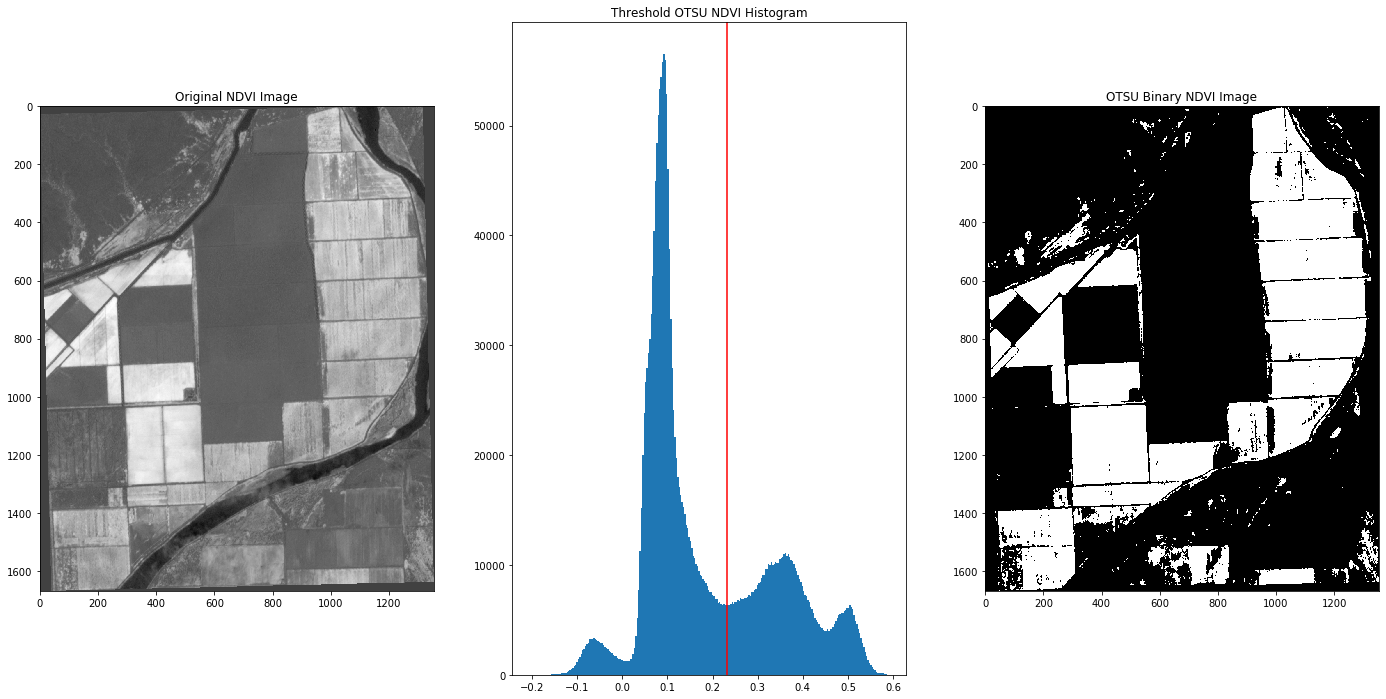

Label(value='Current date is: 20180422')

In [20]:
# resets current date to the first option
current_date = user_select_date_range[0]

# button widgets defined
prev_button = widgets.Button(description="Previous Image", disable=False, button_style='',
                            tooltip=" ",)

next_button = widgets.Button(description="Next Image", disable=False, button_style='',
                            tooltip= " ",)


add_button = widgets.Button(description='Good Image',
                            disabled=False,
                            button_style='', 
                            tooltip='Click me to add Image to good list',
                            icon='check')
remove_button = widgets.Button(description='Bad Image',
                            disabled=False,
                            button_style='', 
                            tooltip='Click me to add Image to good list',
                            icon='remove')

# button on_click eventhandler functions
def add_button_eventhandler(img_lst, obj):
    print("Old Good Image List: ", img_lst)
    global current_date
    img_lst.append(current_date)
    print("New Good Image List: ", img_lst)

def remove_button_eventhandler(img_lst, obj):
    print("Old Bad Image List: ", img_lst)
    global current_date
    img_lst.append(current_date)
    print("New Bad Image List: ", img_lst)

def prev_button_eventhandler(obj):
    global user_select_date_range
    global current_date
    current_index = user_select_date_range.index(current_date)
    current_date = user_select_date_range[current_index-1]
    clear_output()
    show_ndvi_qaqc(ndvi_img_dict.get(current_date), binary_algo)
    button_layout = HBox([prev_button, next_button, add_button, remove_button])
    display(Label("Current date is: {}".format(current_date)), button_layout)

def next_button_eventhandler(obj):
    global user_select_date_range
    global current_date
    current_index = user_select_date_range.index(current_date)
    if current_index+1 < len(user_select_date_range):
        current_date = user_select_date_range[current_index+1]
    else:
        current_date = current_date
    clear_output()
    show_ndvi_qaqc(ndvi_img_dict.get(current_date), binary_algo)
    button_layout = HBox([prev_button, next_button, add_button, remove_button])
    display(Label("Current date is: {}".format(current_date)), button_layout)

# attach buttons to eventhandlers
add_button.on_click(partial(add_button_eventhandler, good_qaqc_img_lst))
remove_button.on_click(partial(remove_button_eventhandler, bad_qaqc_img_lst))
prev_button.on_click(prev_button_eventhandler)
next_button.on_click(next_button_eventhandler)
# button and plot images layout
button_layout = HBox([prev_button, next_button, add_button, remove_button])
display(show_ndvi_qaqc(ndvi_img_dict.get(current_date), binary_algo),
        Label("Current date is: {}".format(current_date)),
        button_layout)

#### User Chosen QAQC'ed NDVI Imagery Dates

In [21]:
good_qaqc_img_lst = list(set(good_qaqc_img_lst))
bad_qaqc_img_lst = list(set(bad_qaqc_img_lst))
print("User Determined {} NDVI Images of Good Quality".format(len(good_qaqc_img_lst)))
display(good_qaqc_img_lst)
print("User Determined {} NDVI Images of Bad Quality. Not included in further analysis.".format(len(bad_qaqc_img_lst)))
display(bad_qaqc_img_lst)

User Determined 18 NDVI Images of Good Quality


['20180208',
 '20180210',
 '20180407',
 '20180408',
 '20180406',
 '20180303',
 '20180413',
 '20180314',
 '20180317',
 '20180222',
 '20180205',
 '20180410',
 '20180414',
 '20180216',
 '20180206',
 '20180301',
 '20180421',
 '20180412']

User Determined 7 NDVI Images of Bad Quality. Not included in further analysis.


['20180422',
 '20180315',
 '20180419',
 '20180212',
 '20180309',
 '20180308',
 '20180217']

##### User Set Period Summary Input Dates

The user can define as many comparison periods as desired in the format provided below.

In [22]:
period_lst = [["2018-02-01", "2018-02-28"],
              ["2018-03-01", "2018-03-31"],
              ["2018-04-01", "2018-04-30"]]

period_datetime_lst = []
for period in period_lst:
    temp = []
    for p in period:
        _ = datetime.datetime.strptime(p, '%Y-%m-%d').date()
        temp.append(_)
    period_datetime_lst.append(temp)
display(period_datetime_lst)

[[datetime.date(2018, 2, 1), datetime.date(2018, 2, 28)],
 [datetime.date(2018, 3, 1), datetime.date(2018, 3, 31)],
 [datetime.date(2018, 4, 1), datetime.date(2018, 4, 30)]]

In [23]:
period_dict = {k: [] for k in range(len(period_datetime_lst))}
print("Intialized period_dict: ", period_dict)
print("\n")
for date_str in good_qaqc_img_lst:
    date_con = datetime.datetime.strptime(date_str, '%Y%m%d').date()
    for indx, period in enumerate(period_datetime_lst):
        if period[0] <= date_con <= period[1]:
            period_dict.get(indx).append(date_str)
print("Finalized period_dict: ", period_dict)

Intialized period_dict:  {0: [], 1: [], 2: []}


Finalized period_dict:  {0: ['20180208', '20180210', '20180222', '20180205', '20180216', '20180206'], 1: ['20180303', '20180314', '20180317', '20180301'], 2: ['20180407', '20180408', '20180406', '20180413', '20180410', '20180414', '20180421', '20180412']}


In [24]:
p_lst_options = []
for date_pair in period_datetime_lst:
    d1 = date_pair[0].strftime('%Y/%m/%d')
    d2 = date_pair[1].strftime('%Y/%m/%d')
    p_lst_options.append("{} to {}".format(d1, d2))

### Visualization of Stacked Binary NDVI Masks for Frequency Determination

In [29]:
def show_ndvi_period_binary_comparison(imageid_1, imageid_2, binary_algo,
                                       title1='NDVI Image Binary Stack 1',
                                       title2='NDVI Image Binary Stack 2',
                                       title3='NDVI Difference of Stack 1 - Stack 2'):
    if isinstance(imageid_1, list) and isinstance(imageid_2, list):
        display_img = []
        for i in [imageid_1, imageid_2]:
            temp_lst = []
            for _id in i:
                temp_arr = ndvi_img_dict.get(_id).get("{}_binary_array".format(binary_algo))
                temp_lst.append(temp_arr)
            stacked = np.dstack(temp_lst)
            sum_array = np.sum(stacked, axis=2)
            display_img.append(sum_array)
        # these are arrays "-" overloaded for element-wise subtraction
        difference = display_img[0] - display_img[1]
        # plot display
        plt.figure(figsize=(30, 12))
        plt.subplot(1, 3, 1)
        plt.imshow(display_img[0], cmap=plt.cm.viridis)
        plt.title(title1)
        plt.colorbar()
        plt.clim(-1, 1)
        plt.subplot(1, 3, 2)
        plt.imshow(display_img[1], cmap=plt.cm.viridis)
        plt.title(title2)
        plt.colorbar()
        plt.clim(-1, 1)
        plt.subplot(1, 3, 3)
        plt.imshow(difference, cmap=plt.cm.viridis)
        plt.title(title3)
        plt.colorbar()
        plt.clim(-1, 1)
        plt.show()
    else:
        print("Input types do not match")
        return 1

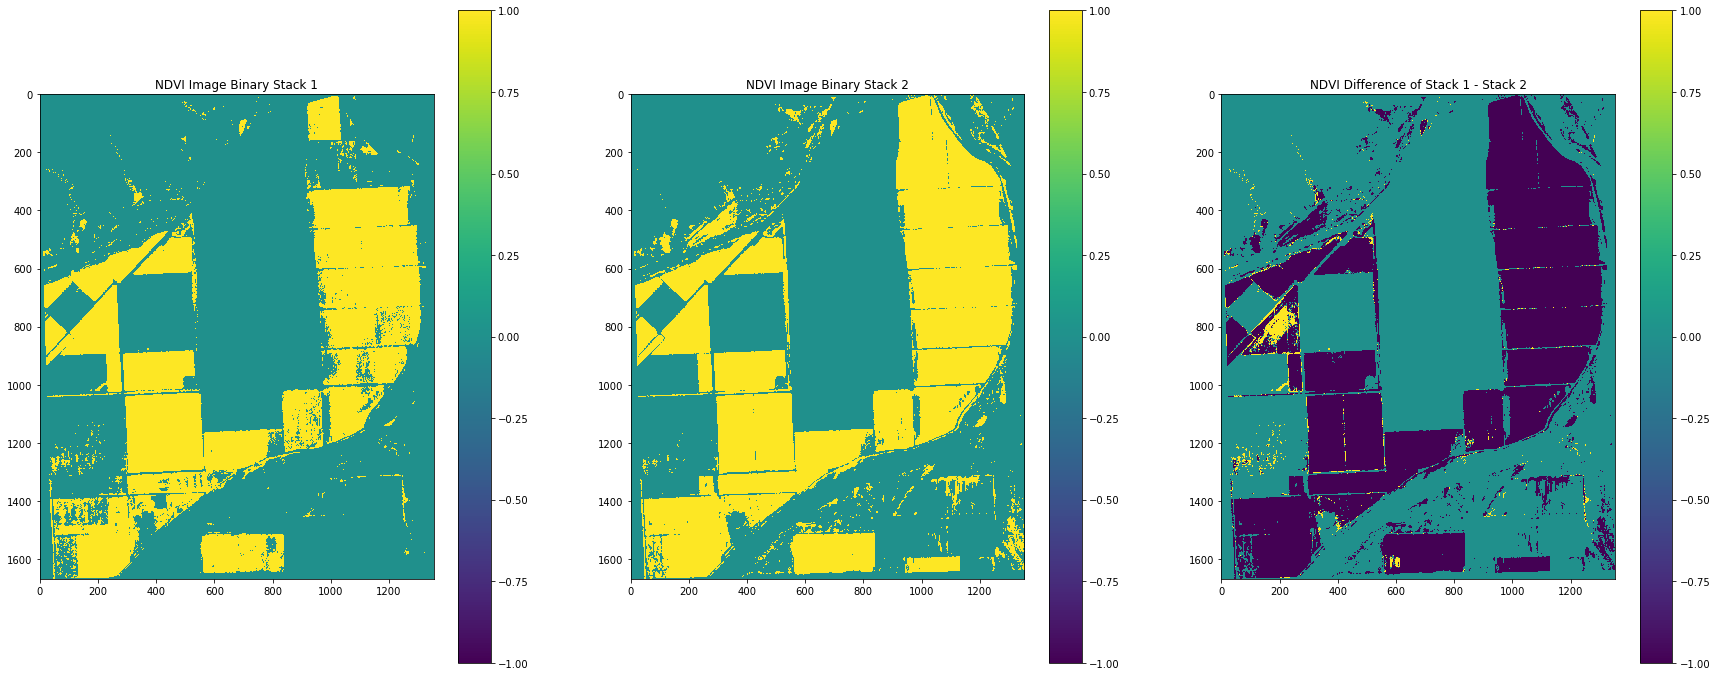

In [30]:
binary_difference_options = p_lst_options
first_binary_dropdown = widgets.Dropdown(options=binary_difference_options,
                                         value=binary_difference_options[0],
                                         description=' ',)
second_binary_dropdown = widgets.Dropdown(options=binary_difference_options,
                                          value=binary_difference_options[-1],
                                          description=' ',)
binary_clear_button = widgets.Button(description='Clear all Images',
                                     disabled=False,
                                     button_style='', 
                                     tooltip='Click me to Clear all Images from display',
                                     icon='remove')


def binary_clear_button_eventhandler(obj):
    clear_output()
    display(HBox([Label("Please choose dates to compare: "), first_binary_dropdown,
                  second_binary_dropdown, binary_clear_button]))
    
def binary_first_onchange(change):
    if change['type'] == 'change' and change['name'] == 'value':
        indx1 = p_lst_options.index(change['new'])
        indx2 = p_lst_options.index(second_binary_dropdown.value)
        show_ndvi_period_binary_comparison(period_dict.get(indx1), period_dict.get(indx2), binary_algo)
    
def binary_second_onchange(change):
    if change['type'] == 'change' and change['name'] == 'value':
        indx1 = p_lst_options.index(first_binary_dropdown.value)
        indx2 = p_lst_options.index(change['new'])
        show_ndvi_period_binary_comparison(period_dict.get(indx1), period_dict.get(indx2), binary_algo)

first_binary_dropdown.observe(binary_first_onchange)
second_binary_dropdown.observe(binary_second_onchange)
binary_clear_button.on_click(binary_clear_button_eventhandler)

display(HBox([Label("Please choose dates to compare: "), first_binary_dropdown, second_binary_dropdown, binary_clear_button]))
indx_binary_2 = len(p_lst_options) - 1
show_ndvi_period_binary_comparison(period_dict.get(0), period_dict.get(indx_binary_2), binary_algo)

## Visualization of NDVI Images for Change Detection

In [31]:
def show_ndvi_date_comparison(imageid_1, imageid_2):
    if isinstance(imageid_1, str) and isinstance(imageid_2, str):
        ndvi_1 = ndvi_img_dict.get(imageid_1).get("display_array")
        ndvi_2 = ndvi_img_dict.get(imageid_2).get("display_array")
        # these are arrays "-" overloaded for element-wise subtraction
        difference = ndvi_1 - ndvi_2
        # plot display
        plt.figure(figsize=(30, 12))
        plt.subplot(1, 3, 1)
        plt.imshow(ndvi_1, cmap=plt.cm.gray)
        plt.title("NDVI Image for {}".format(imageid_1))
        plt.colorbar()
        plt.clim(-1, 1)
        plt.subplot(1, 3, 2)
        plt.imshow(ndvi_2, cmap=plt.cm.gray)
        plt.title("NDVI Image for {}".format(imageid_2))
        plt.colorbar()
        plt.clim(-1, 1)
        plt.subplot(1, 3, 3)
        plt.imshow(difference, cmap=plt.cm.viridis)
        plt.title("NDVI Difference of {} - {}".format(imageid_1, imageid_2))
        plt.colorbar()
        plt.clim(-1, 1)
        plt.show()   
    else:
        print("Input types do not match")
        return 1

    
def show_ndvi_period_average_comparison(imageid_1, imageid_2,
                                        title1='NDVI Image Average of Stack 1',
                                        title2='NDVI Image Average of Stack 2',
                                        title3='NDVI Difference of Stack 1 - Stack 2'):
    if isinstance(imageid_1, list) and isinstance(imageid_2, list):
        display_img = []
        for i in [imageid_1, imageid_2]:
            temp_lst = []
            for _id in i:
                temp_arr = ndvi_img_dict.get(_id).get("display_array")
                temp_lst.append(temp_arr)
            stacked = np.dstack(temp_lst)
            mean_array = np.mean(stacked, axis=2)
            display_img.append(mean_array)
        # these are arrays "-" overloaded for element-wise subtraction
        difference = display_img[0] - display_img[1]
        # plot display
        plt.figure(figsize=(30, 12))
        plt.subplot(1, 3, 1)
        plt.imshow(display_img[0], cmap=plt.cm.viridis)
        plt.title(title1)
        plt.colorbar()
        plt.clim(-1, 1)
        plt.subplot(1, 3, 2)
        plt.imshow(display_img[1], cmap=plt.cm.viridis)
        plt.title(title2)
        plt.colorbar()
        plt.clim(-1, 1)
        plt.subplot(1, 3, 3)
        plt.imshow(difference, cmap=plt.cm.viridis)
        plt.title(title3)
        plt.colorbar()
        plt.clim(-1, 1)
        plt.show()
    else:
        print("Input types do not match")
        return 1   

Example of Two NDVI Images Compared and Differenced.

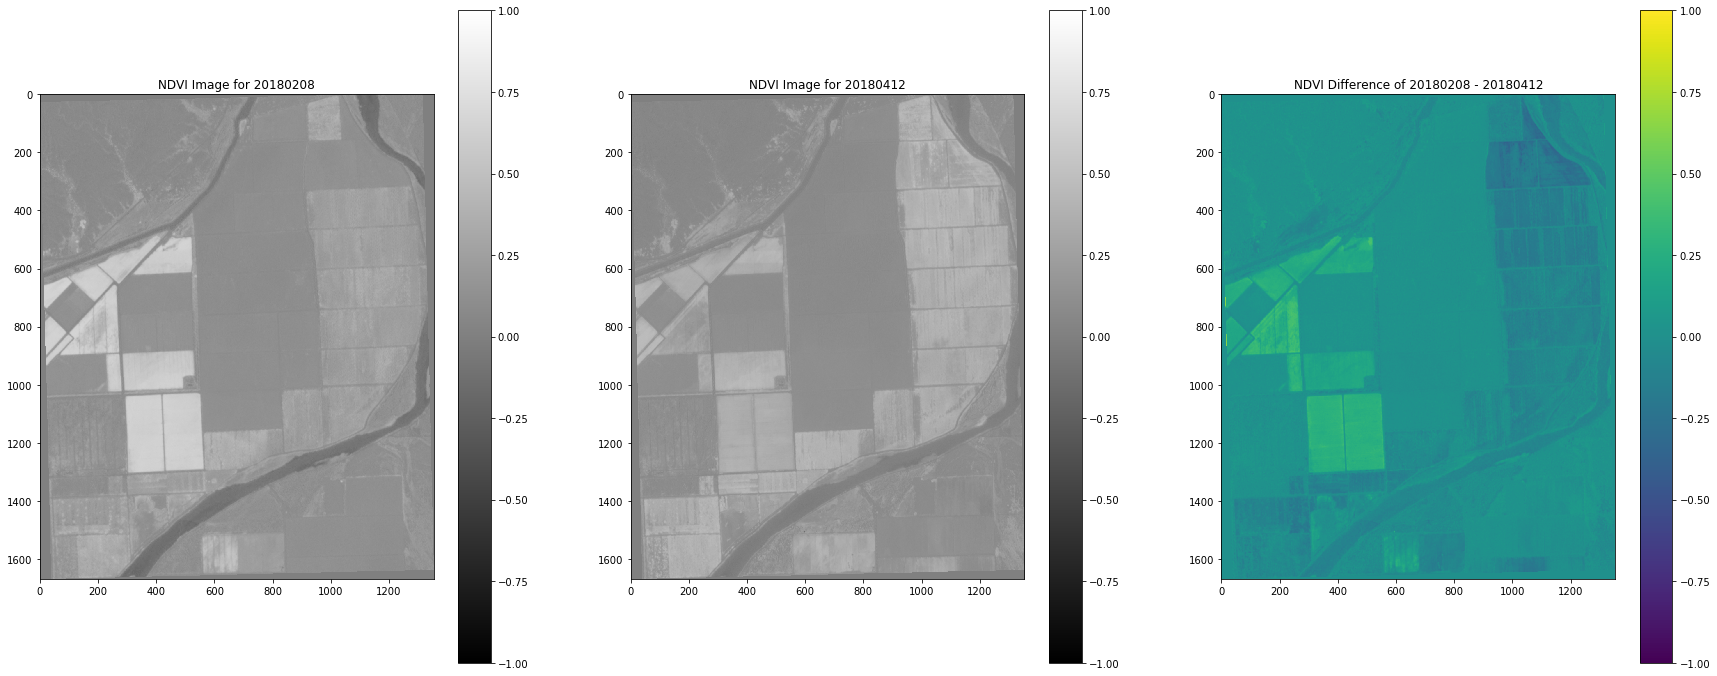

In [32]:
show_ndvi_date_comparison(good_qaqc_img_lst[0], good_qaqc_img_lst[-1])

Example of Two Period Averaged NDVI Images Compared and Differenced.

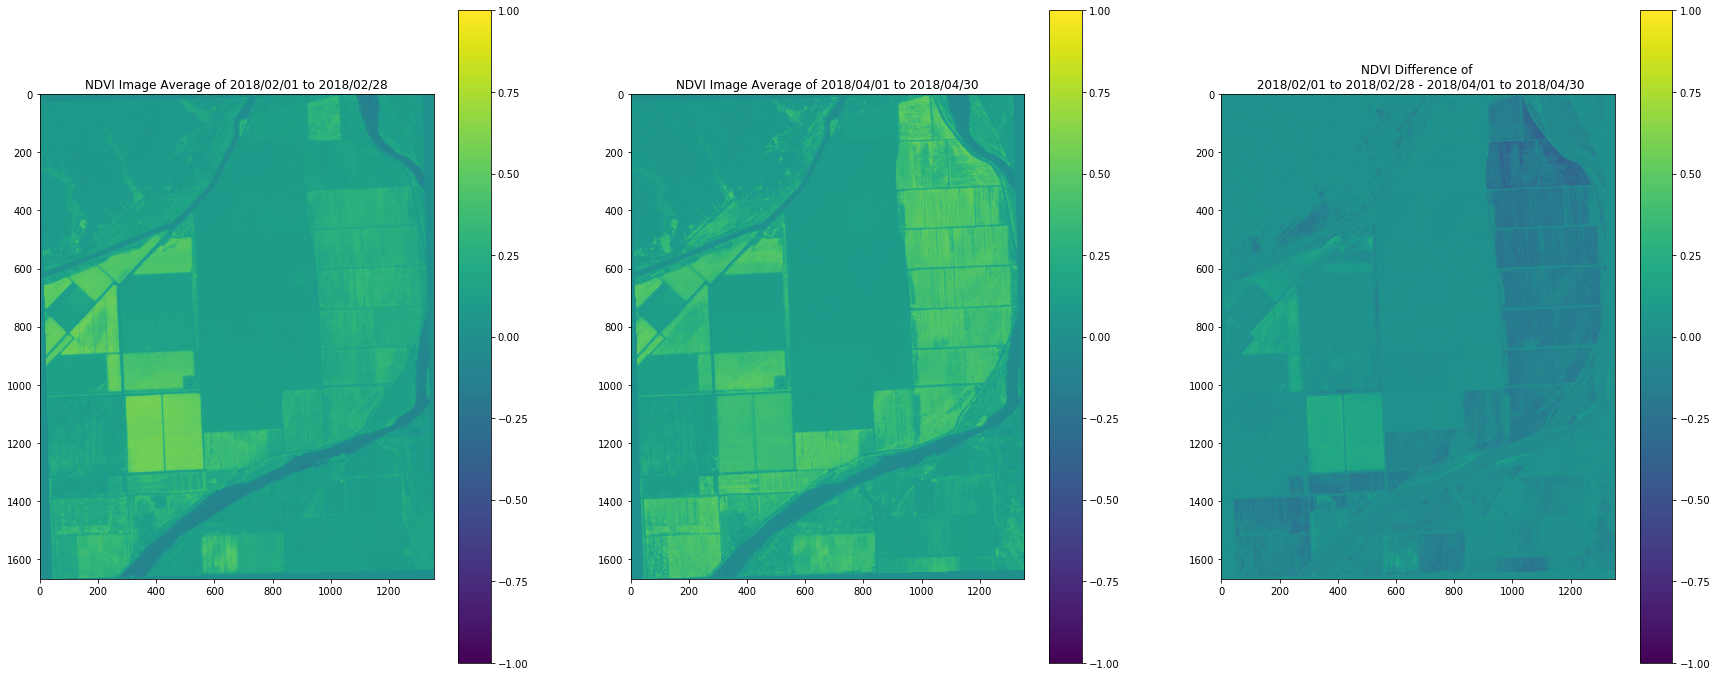

In [33]:
show_ndvi_period_average_comparison(period_dict.get(0), period_dict.get(2),
                                    title1='NDVI Image Average of {}'.format(p_lst_options[0]),
                                    title2='NDVI Image Average of {}'.format(p_lst_options[-1]),
                                    title3='NDVI Difference of \n {} - {}'.format(p_lst_options[0], p_lst_options[-1]))

### Visualizer for Comparing Two Specific Dates

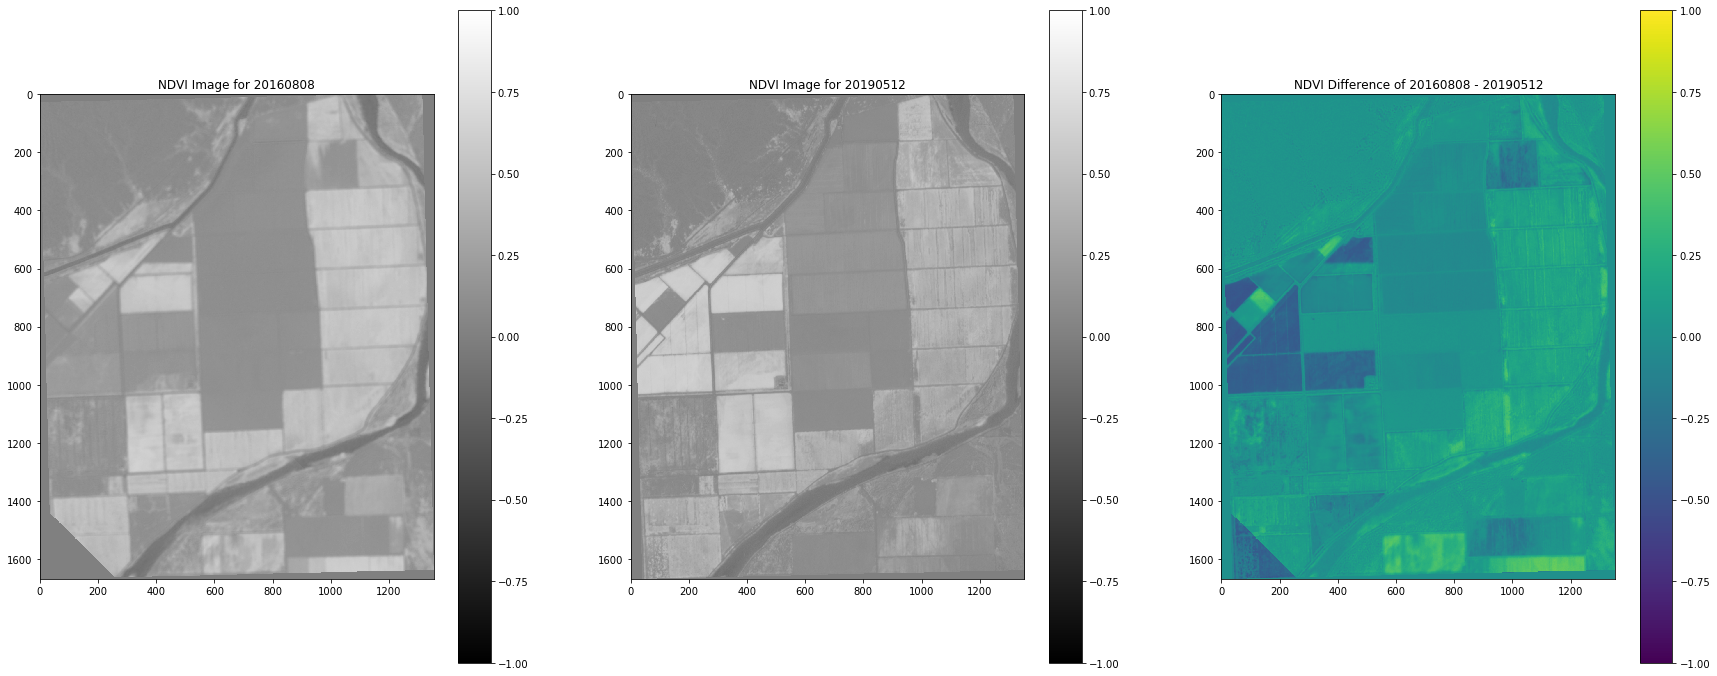

In [34]:
specific_date_difference_options = list(ndvi_img_dict.keys())
first_date_dropdown = widgets.Dropdown(options=specific_date_difference_options,
                                       value=specific_date_difference_options[0],
                                       description=' ',)
second_date_dropdown = widgets.Dropdown(options=specific_date_difference_options,
                                        value=specific_date_difference_options[-1],
                                        description=' ',)
date_clear_button = widgets.Button(description='Clear all Images',
                                   disabled=False,
                                   button_style='', 
                                   tooltip='Click me to Clear all Images from display',
                                   icon='remove')


def clear_button_eventhandler(obj):
    clear_output()
    display(HBox([Label("Please choose dates to compare: "), first_date_dropdown,
                  second_date_dropdown, date_clear_button]))
    
def first_onchange(change):
    if change['type'] == 'change' and change['name'] == 'value':
        show_ndvi_date_comparison(change['new'], second_date_dropdown.value)
    
def second_onchange(change):
    if change['type'] == 'change' and change['name'] == 'value':
        show_ndvi_date_comparison(first_date_dropdown.value, change['new'])

first_date_dropdown.observe(first_onchange)
second_date_dropdown.observe(second_onchange)
date_clear_button.on_click(clear_button_eventhandler)

display(HBox([Label("Please choose dates to compare: "), first_date_dropdown,
              second_date_dropdown, date_clear_button]))
show_ndvi_date_comparison(specific_date_difference_options[0], specific_date_difference_options[-1])

### Visualizer for Comparing Average Period NDVI Images  (two user defined time periods)

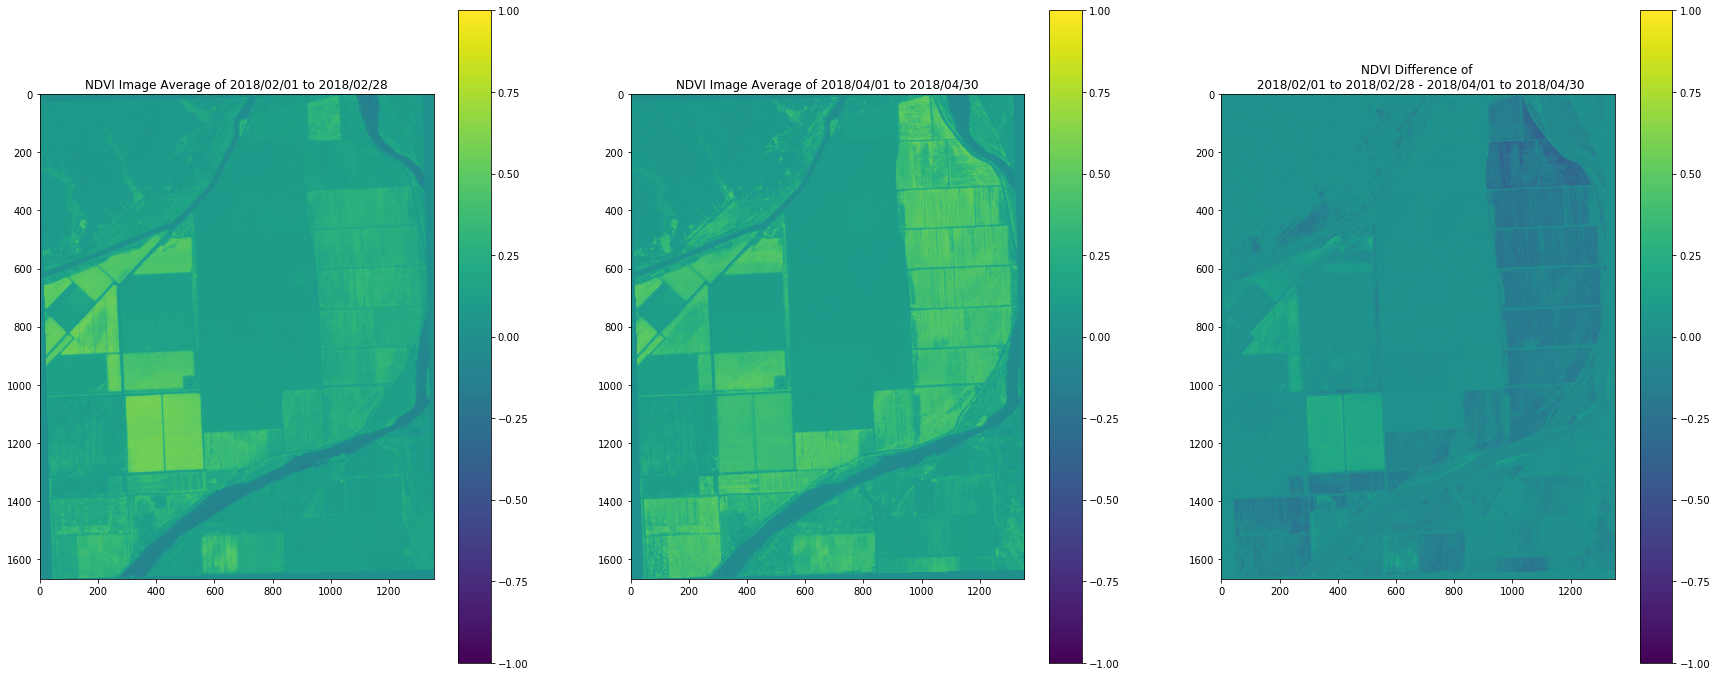

In [35]:
ave_difference_options = p_lst_options
first_ave_dropdown = widgets.Dropdown(options=ave_difference_options,
                                      value=ave_difference_options[0],
                                      description=' ',)
second_ave_dropdown = widgets.Dropdown(options=ave_difference_options,
                                       value=ave_difference_options[-1],
                                       description=' ',)
ave_clear_button = widgets.Button(description='Clear all Images',
                                  disabled=False,
                                  button_style='', 
                                  tooltip='Click me to Clear all Images from display',
                                  icon='remove')


def ave_clear_button_eventhandler(obj):
    clear_output()
    display(HBox([Label("Please choose dates to compare: "), first_ave_dropdown,
                  second_ave_dropdown, ave_clear_button]))
    
def ave_first_onchange(change):
    if change['type'] == 'change' and change['name'] == 'value':
        indx1 = p_lst_options.index(change['new'])
        indx2 = p_lst_options.index(second_ave_dropdown.value)
        show_ndvi_period_average_comparison(period_dict.get(indx1), period_dict.get(indx2),
                                            title1='NDVI Image Average of {}'.format(p_lst_options[indx1]),
                                            title2='NDVI Image Average of {}'.format(p_lst_options[indx2]),
                                            title3='NDVI Difference of \n {} - {}'.format(p_lst_options[indx1],
                                                                                          p_lst_options[indx2]))
    
def ave_second_onchange(change):
    if change['type'] == 'change' and change['name'] == 'value':
        indx1 = p_lst_options.index(first_ave_dropdown.value)
        indx2 = p_lst_options.index(change['new'])
        show_ndvi_period_average_comparison(period_dict.get(indx1), period_dict.get(indx2),
                                            title1='NDVI Image Average of {}'.format(p_lst_options[indx1]),
                                            title2='NDVI Image Average of {}'.format(p_lst_options[indx2]),
                                            title3='NDVI Difference of \n {} - {}'.format(p_lst_options[indx1],
                                                                                          p_lst_options[indx2]))

first_ave_dropdown.observe(ave_first_onchange)
second_ave_dropdown.observe(ave_second_onchange)
ave_clear_button.on_click(ave_clear_button_eventhandler)

display(HBox([Label("Please choose dates to compare: "), first_ave_dropdown, second_ave_dropdown, ave_clear_button]))
indx_ave_2 = len(p_lst_options) - 1
show_ndvi_period_average_comparison(period_dict.get(0), period_dict.get(indx_ave_2),
                                    title1='NDVI Image Average of {}'.format(p_lst_options[0]),
                                    title2='NDVI Image Average of {}'.format(p_lst_options[indx_ave_2]),
                                    title3='NDVI Difference of \n {} - {}'.format(p_lst_options[0], p_lst_options[indx_ave_2]))

End of Analysis, QAQC, and Visualization Sections.

### Export 

#### Export the Good and Bad QAQC NDVI Imagery List of Dates Based on User Selection and QAQC

In [36]:
glen = len(good_qaqc_img_lst)
blen = len(bad_qaqc_img_lst)
if glen != blen:
    if glen > blen:
        export_good_lst = [x for x in good_qaqc_img_lst]
        export_bad_lst = bad_qaqc_img_lst + [np.nan]*(glen-blen)
    elif glen < blen:
        export_bad_lst = [x for x in bad_qaqc_img_lst]
        export_good_lst = good_qaqc_img_lst + [np.nan]*(blen-glen)
assert len(export_good_lst) == len(export_bad_lst)
df_qaqc = pd.DataFrame()
df_qaqc["Good QAQC NDVI Image Dates"] = export_good_lst
df_qaqc["Bad QAQC NDVI Image Dates"] = export_bad_lst
display(df_qaqc)

,Good QAQC NDVI Image Dates,Bad QAQC NDVI Image Dates
0,20180208,20180422
1,20180210,20180315
2,20180407,20180419
3,20180408,20180212
4,20180406,20180309
5,20180303,20180308
6,20180413,20180217
7,20180314,NaN
8,20180317,NaN
9,20180222,NaN


In [37]:
list_output_path = os.path.join(os.path.dirname(planet_input_dir),
                                "Good_and_Bad_QAQC_Image_Dates_{}.csv".format(datetime.datetime.now().date()))
# Writes Dataframe to *.csv
df_qaqc.to_csv(list_output_path, sep=",", na_rep="", index=False)

#### Export Rasters of Stacked Binary NDVI Masks

In [38]:
stacked_output_dir = os.path.join(os.path.dirname(planet_input_dir),
                                  "poh_final_NDVI_Stacked_Binary_{}".format(binary_algo.upper()))
if not os.path.exists(stacked_output_dir):
    os.mkdir(stacked_output_dir)
print("All stacked binary period rasters will be written too: ")
print(stacked_output_dir)

All stacked binary period rasters will be written too: 
C:\Users\zleady\Desktop\ST_1867\LC\lcr_active_20200621\poh_final_NDVI_Stacked_Binary_OTSU


In [39]:
stack_img_dict = {}
for period in sorted(list(period_dict.keys())):
    period_ids = period_dict.get(period) 
    temp_lst = []
    for p_ids in period_ids:
        temp_arr = ndvi_img_dict.get(p_ids).get("{}_binary_array".format(binary_algo))
        temp_lst.append(temp_arr)
    stacked = np.dstack(temp_lst)
    sum_array = np.sum(stacked, axis=2)
    stack_img_dict[period] = sum_array
print("{} Stacked Binary Period Rasters".format(len(list(stack_img_dict.keys()))))
display(list(stack_img_dict.keys()))

difference_img_dict = {}
for p1 in sorted(list(stack_img_dict.keys())):
    for p2 in sorted(list(stack_img_dict.keys())):
        if not p1 == p2:
            p1_arr = stack_img_dict.get(p1)
            p2_arr = stack_img_dict.get(p2)
            difference_array = p1_arr - p2_arr
            p1_name = p_lst_options[p1].replace("/", "_").replace(" to ", "_") 
            p2_name = p_lst_options[p2].replace("/", "_").replace(" to ", "_")
            difference_img_dict["{}-{}".format(p1_name, p2_name)] = difference_array
print("{} Difference Stacked Binary Period Rasters".format(len(list(difference_img_dict.keys()))))
display(list(difference_img_dict.keys()))

stack_img_dict = {p_lst_options[k].replace("/", "_").replace(" to ", "_"): v for k, v in stack_img_dict.items()}
display(list(stack_img_dict.keys()))


def write_img_dict_to_raster(img_dict, reference_raster_date):
    retrieve_path = ndvi_img_dict.get("{}".format(reference_raster_date)).get("path")
    assert os.path.exists(retrieve_path)
    print("{} date raster being used as kwargs reference".format(reference_raster_date))
    for key in list(img_dict.keys()):
        temp_arr = img_dict.get(key)
        with rasterio.open(retrieve_path) as orig_dst:
            kwargs = orig_dst.meta
            kwargs.update(dtype=rasterio.float32, count=1)        
            output_path = os.path.join(output_dir,
                                       "stacked_{}_b.tif".format(key))
            with rasterio.open(output_path, 'w', **kwargs) as dst:
                dst.write_band(1, img_dict.get(key).astype(rasterio.float32))
        print("Wrote {} stacked array".format(key))

3 Stacked Binary Period Rasters


[0, 1, 2]

6 Difference Stacked Binary Period Rasters


['2018_02_01_2018_02_28-2018_03_01_2018_03_31',
 '2018_02_01_2018_02_28-2018_04_01_2018_04_30',
 '2018_03_01_2018_03_31-2018_02_01_2018_02_28',
 '2018_03_01_2018_03_31-2018_04_01_2018_04_30',
 '2018_04_01_2018_04_30-2018_02_01_2018_02_28',
 '2018_04_01_2018_04_30-2018_03_01_2018_03_31']

['2018_02_01_2018_02_28', '2018_03_01_2018_03_31', '2018_04_01_2018_04_30']

In [40]:
# Write out each Stacked Period Binary Mask to a Raster
write_img_dict_to_raster(stack_img_dict, good_qaqc_img_lst[0])
# Write out each Stacked Period Difference Binary Mask to a Raster
write_img_dict_to_raster(difference_img_dict, good_qaqc_img_lst[-1])

20180208 date raster being used as kwargs reference
Wrote 2018_02_01_2018_02_28 stacked array
Wrote 2018_03_01_2018_03_31 stacked array
Wrote 2018_04_01_2018_04_30 stacked array
20180412 date raster being used as kwargs reference
Wrote 2018_02_01_2018_02_28-2018_03_01_2018_03_31 stacked array
Wrote 2018_02_01_2018_02_28-2018_04_01_2018_04_30 stacked array
Wrote 2018_03_01_2018_03_31-2018_02_01_2018_02_28 stacked array
Wrote 2018_03_01_2018_03_31-2018_04_01_2018_04_30 stacked array
Wrote 2018_04_01_2018_04_30-2018_02_01_2018_02_28 stacked array
Wrote 2018_04_01_2018_04_30-2018_03_01_2018_03_31 stacked array


#### Export Rasters and PNGs of All Two Specific Date Comparisons

In [41]:
# Compare two specific date options
compare_options = itertools.combinations(sorted(good_qaqc_img_lst), 2)
compare_options = sorted(list(set(compare_options)))
display(compare_options)

[('20180205', '20180206'),
 ('20180205', '20180208'),
 ('20180205', '20180210'),
 ('20180205', '20180216'),
 ('20180205', '20180222'),
 ('20180205', '20180301'),
 ('20180205', '20180303'),
 ('20180205', '20180314'),
 ('20180205', '20180317'),
 ('20180205', '20180406'),
 ('20180205', '20180407'),
 ('20180205', '20180408'),
 ('20180205', '20180410'),
 ('20180205', '20180412'),
 ('20180205', '20180413'),
 ('20180205', '20180414'),
 ('20180205', '20180421'),
 ('20180206', '20180208'),
 ('20180206', '20180210'),
 ('20180206', '20180216'),
 ('20180206', '20180222'),
 ('20180206', '20180301'),
 ('20180206', '20180303'),
 ('20180206', '20180314'),
 ('20180206', '20180317'),
 ('20180206', '20180406'),
 ('20180206', '20180407'),
 ('20180206', '20180408'),
 ('20180206', '20180410'),
 ('20180206', '20180412'),
 ('20180206', '20180413'),
 ('20180206', '20180414'),
 ('20180206', '20180421'),
 ('20180208', '20180210'),
 ('20180208', '20180216'),
 ('20180208', '20180222'),
 ('20180208', '20180301'),
 

In [42]:
# PNG Export
png_output_dir = os.path.join(os.path.dirname(planet_input_dir),
                              "Two_Date_Comparison_PNG_{}".format(datetime.datetime.now().date()))
if not os.path.exists(png_output_dir):
    os.mkdir(png_output_dir)

In [43]:
# PNG Export
def two_date_png_export(options, png_output_dir):
    ndvi_1 = ndvi_img_dict.get(opt[0]).get("display_array")
    ndvi_2 = ndvi_img_dict.get(opt[1]).get("display_array")
    # these are arrays "-" overloaded for element-wise subtraction
    difference = ndvi_1 - ndvi_2
    # plot display
    plt.figure(figsize=(30, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(ndvi_1, cmap=plt.cm.gray)
    plt.title("NDVI Image for {}".format(opt[0]))
    plt.colorbar()
    plt.clim(-1, 1)
    plt.subplot(1, 3, 2)
    plt.imshow(ndvi_2, cmap=plt.cm.gray)
    plt.title("NDVI Image for {}".format(opt[1]))
    plt.colorbar()
    plt.clim(-1, 1)
    plt.subplot(1, 3, 3)
    plt.imshow(difference, cmap=plt.cm.viridis)
    plt.title("NDVI Difference of {} - {}".format(opt[0], opt[1]))
    plt.colorbar()
    plt.clim(-1, 1)
    plt.savefig(os.path.join(png_output_dir, "{}_{}_NDVI_compare.png".format(opt[0], opt[1])))
    plt.close()
    return 0

In [44]:
for opt in compare_options:
    two_date_png_export(opt, png_output_dir)
    print("Wrote two date NDVI compare PNG for {}".format(opt))

Wrote two date NDVI compare PNG for ('20180205', '20180206')
Wrote two date NDVI compare PNG for ('20180205', '20180208')
Wrote two date NDVI compare PNG for ('20180205', '20180210')
Wrote two date NDVI compare PNG for ('20180205', '20180216')
Wrote two date NDVI compare PNG for ('20180205', '20180222')
Wrote two date NDVI compare PNG for ('20180205', '20180301')
Wrote two date NDVI compare PNG for ('20180205', '20180303')
Wrote two date NDVI compare PNG for ('20180205', '20180314')
Wrote two date NDVI compare PNG for ('20180205', '20180317')
Wrote two date NDVI compare PNG for ('20180205', '20180406')
Wrote two date NDVI compare PNG for ('20180205', '20180407')
Wrote two date NDVI compare PNG for ('20180205', '20180408')
Wrote two date NDVI compare PNG for ('20180205', '20180410')
Wrote two date NDVI compare PNG for ('20180205', '20180412')
Wrote two date NDVI compare PNG for ('20180205', '20180413')
Wrote two date NDVI compare PNG for ('20180205', '20180414')
Wrote two date NDVI comp

Wrote two date NDVI compare PNG for ('20180407', '20180413')
Wrote two date NDVI compare PNG for ('20180407', '20180414')
Wrote two date NDVI compare PNG for ('20180407', '20180421')
Wrote two date NDVI compare PNG for ('20180408', '20180410')
Wrote two date NDVI compare PNG for ('20180408', '20180412')
Wrote two date NDVI compare PNG for ('20180408', '20180413')
Wrote two date NDVI compare PNG for ('20180408', '20180414')
Wrote two date NDVI compare PNG for ('20180408', '20180421')
Wrote two date NDVI compare PNG for ('20180410', '20180412')
Wrote two date NDVI compare PNG for ('20180410', '20180413')
Wrote two date NDVI compare PNG for ('20180410', '20180414')
Wrote two date NDVI compare PNG for ('20180410', '20180421')
Wrote two date NDVI compare PNG for ('20180412', '20180413')
Wrote two date NDVI compare PNG for ('20180412', '20180414')
Wrote two date NDVI compare PNG for ('20180412', '20180421')
Wrote two date NDVI compare PNG for ('20180413', '20180414')
Wrote two date NDVI comp

In [45]:
# Raster Export
tcd_output_dir = os.path.join(os.path.dirname(planet_input_dir),
                              "Two_Date_Comparison_Raster_{}".format(datetime.datetime.now().date()))
if not os.path.exists(tcd_output_dir):
    os.mkdir(tcd_output_dir)

In [46]:
# Raster Export
def write_two_compare_difference_to_raster(opt, tcd_output_dir):
    ndvi_1 = ndvi_img_dict.get(opt[0]).get("display_array")
    ndvi_2 = ndvi_img_dict.get(opt[1]).get("display_array")
    # these are arrays "-" overloaded for element-wise subtraction
    difference = ndvi_1 - ndvi_2
    retrieve_path = ndvi_img_dict.get("{}".format(opt[0])).get("path")
    assert os.path.exists(retrieve_path)
    with rasterio.open(retrieve_path) as orig_dst:
        kwargs = orig_dst.meta
        kwargs.update(dtype=rasterio.float32, count=1)        
        output_path = os.path.join(tcd_output_dir,
                                   "tcd_ndvi_{}_{}_diff.tif".format(opt[0], opt[1]))
        with rasterio.open(output_path, 'w', **kwargs) as dst:
            dst.write_band(1, difference.astype(rasterio.float32))

In [47]:
for opt in compare_options:
    write_two_compare_difference_to_raster(opt, tcd_output_dir)
    print("Wrote two date NDVI compare Difference Raster for {}".format(opt))

Wrote two date NDVI compare Difference Raster for ('20180205', '20180206')
Wrote two date NDVI compare Difference Raster for ('20180205', '20180208')
Wrote two date NDVI compare Difference Raster for ('20180205', '20180210')
Wrote two date NDVI compare Difference Raster for ('20180205', '20180216')
Wrote two date NDVI compare Difference Raster for ('20180205', '20180222')
Wrote two date NDVI compare Difference Raster for ('20180205', '20180301')
Wrote two date NDVI compare Difference Raster for ('20180205', '20180303')
Wrote two date NDVI compare Difference Raster for ('20180205', '20180314')
Wrote two date NDVI compare Difference Raster for ('20180205', '20180317')
Wrote two date NDVI compare Difference Raster for ('20180205', '20180406')
Wrote two date NDVI compare Difference Raster for ('20180205', '20180407')
Wrote two date NDVI compare Difference Raster for ('20180205', '20180408')
Wrote two date NDVI compare Difference Raster for ('20180205', '20180410')
Wrote two date NDVI compa

Wrote two date NDVI compare Difference Raster for ('20180314', '20180408')
Wrote two date NDVI compare Difference Raster for ('20180314', '20180410')
Wrote two date NDVI compare Difference Raster for ('20180314', '20180412')
Wrote two date NDVI compare Difference Raster for ('20180314', '20180413')
Wrote two date NDVI compare Difference Raster for ('20180314', '20180414')
Wrote two date NDVI compare Difference Raster for ('20180314', '20180421')
Wrote two date NDVI compare Difference Raster for ('20180317', '20180406')
Wrote two date NDVI compare Difference Raster for ('20180317', '20180407')
Wrote two date NDVI compare Difference Raster for ('20180317', '20180408')
Wrote two date NDVI compare Difference Raster for ('20180317', '20180410')
Wrote two date NDVI compare Difference Raster for ('20180317', '20180412')
Wrote two date NDVI compare Difference Raster for ('20180317', '20180413')
Wrote two date NDVI compare Difference Raster for ('20180317', '20180414')
Wrote two date NDVI compa

#### Export All Average NDVI Period Imagery Comparison

In [48]:
average_compare_options = sorted(list(itertools.combinations(list(period_dict.keys()), 2)))
display(average_compare_options)

[(0, 1), (0, 2), (1, 2)]

In [49]:
# PNG export dir
ave_png_output_dir = os.path.join(os.path.dirname(planet_input_dir),
                                  "Average_Period_Comparison_PNG_{}".format(datetime.datetime.now().date()))
if not os.path.exists(ave_png_output_dir):
    os.mkdir(ave_png_output_dir)

# Raster export dir
ave_raster_output_dir = os.path.join(os.path.dirname(planet_input_dir),
                                     "Average_Period_Comparison_Raster_{}".format(datetime.datetime.now().date()))
if not os.path.exists(ave_raster_output_dir):
    os.mkdir(ave_raster_output_dir)

In [50]:
# PNG export function        
def write_average_period_png(opt, ave_png_output_dir):
    display_img = []
    for i in opt:
        date_lst = period_dict.get(i)
        temp_lst = []
        for date in date_lst:
            temp_arr = ndvi_img_dict.get(date).get("display_array")
            temp_lst.append(temp_arr)
        stacked = np.dstack(temp_lst)
        mean_array = np.mean(stacked, axis=2)
        display_img.append(mean_array)
    # these are arrays "-" overloaded for element-wise subtraction
    difference = display_img[0] - display_img[1]
    # plot display
    plt.figure(figsize=(30, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(display_img[0], cmap=plt.cm.viridis)
    plt.title("NDVI Image Average of {}".format(p_lst_options[opt[0]]))
    plt.colorbar()
    plt.clim(-1, 1)
    plt.subplot(1, 3, 2)
    plt.imshow(display_img[1], cmap=plt.cm.viridis)
    plt.title("NDVI Image Average of {}".format(p_lst_options[opt[1]]))
    plt.colorbar()
    plt.clim(-1, 1)
    plt.subplot(1, 3, 3)
    plt.imshow(difference, cmap=plt.cm.viridis)
    plt.title("Difference of NDVI Image Averages of \n {} - {}".format(p_lst_options[opt[0]],
                                                                    p_lst_options[opt[1]]))
    plt.colorbar()
    plt.clim(-1, 1)
    path_date0 = p_lst_options[opt[0]].replace("/", "_").replace(" to ", "_")
    path_date1 = p_lst_options[opt[1]].replace("/", "_").replace(" to ", "_")
    plt.savefig(os.path.join(ave_png_output_dir, "{}_{}_Average_NDVI_compare.png".format(path_date0, path_date1)))
    plt.close()
    return 0

# Raster export function
def write_average_period_raster(opt, ave_raster_output_dir):
    display_img = []
    for i in opt:
        date_lst = period_dict.get(i)
        temp_lst = []
        for date in date_lst:
            temp_arr = ndvi_img_dict.get(date).get("display_array")
            temp_lst.append(temp_arr)
        stacked = np.dstack(temp_lst)
        mean_array = np.mean(stacked, axis=2)
        display_img.append(mean_array)
    # these are arrays "-" overloaded for element-wise subtraction
    difference = display_img[0] - display_img[1]
    write_raster_lst = [['1', display_img[0]], ['2', display_img[1]], ['diff', difference]]    
    retrieve_path = ndvi_img_dict.get("{}".format(period_dict.get(opt[0])[0])).get("path")
    assert os.path.exists(retrieve_path)
    with rasterio.open(retrieve_path) as orig_dst:
        kwargs = orig_dst.meta
        kwargs.update(dtype=rasterio.float32, count=1)        
        path_date0 = p_lst_options[opt[0]].replace("/", "_").replace(" to ", "_")
        path_date1 = p_lst_options[opt[1]].replace("/", "_").replace(" to ", "_")
        for raster in write_raster_lst:
            output_path = os.path.join(ave_raster_output_dir,
                                       "ave_ndvi_{}_{}_{}.tif".format(path_date0, path_date1, raster[0]))
            with rasterio.open(output_path, 'w', **kwargs) as dst:
                dst.write_band(1, raster[1].astype(rasterio.float32))
            dst.close()
    

In [51]:
for opt in average_compare_options:
    write_average_period_png(opt, ave_png_output_dir)
    print("Wrote Period Average NDVI Compare Difference PNG for {} {}".format(p_lst_options[opt[0]], p_lst_options[opt[1]]))
    write_average_period_raster(opt, ave_raster_output_dir)
    print("Wrote Period Average NDVI Compare Difference Raster for {} {}".format(p_lst_options[opt[0]], p_lst_options[opt[1]]))

Wrote Period Average NDVI Compare Difference PNG for 2018/02/01 to 2018/02/28 2018/03/01 to 2018/03/31
Wrote Period Average NDVI Compare Difference Raster for 2018/02/01 to 2018/02/28 2018/03/01 to 2018/03/31
Wrote Period Average NDVI Compare Difference PNG for 2018/02/01 to 2018/02/28 2018/04/01 to 2018/04/30
Wrote Period Average NDVI Compare Difference Raster for 2018/02/01 to 2018/02/28 2018/04/01 to 2018/04/30
Wrote Period Average NDVI Compare Difference PNG for 2018/03/01 to 2018/03/31 2018/04/01 to 2018/04/30
Wrote Period Average NDVI Compare Difference Raster for 2018/03/01 to 2018/03/31 2018/04/01 to 2018/04/30


End of Export Section.

En Fin.